# Крестики-нолики
### Для начала построим саму модель, то есть определим все состояния и переходы:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [2]:
def is_equal(a, b):
    for i in range(4):
        if np.array_equal(a, b):
            return True
        a = np.rot90(a)
    a = np.fliplr(a)
    for i in range(4):
        if np.array_equal(a, b):
            return True
        a = np.rot90(a)
    return False

def game_result(state):
    for res in [-1, 1]:
        if np.any(np.all(state == res, axis=1)):
            return res
        if np.any(np.all(state == res, axis=0)):
            return res
        if state[0, 0] == res and state[1, 1] == res and state[2, 2] == res:
            return res
        if state[0, 2] == res and state[1, 1] == res and state[2, 0] == res:
            return res
    if np.all(state != 0):
        return 0
    return 2 # not finished

def generate_states():
    global generate_states_return_value
    if 'generate_states_return_value' in globals():
        return generate_states_return_value
    states = []
    actions = {}
    groups = []
    prev = 0
    cur = 1
    end = 1
    states.append(np.zeros((3, 3), dtype='int8'))
    for number in range(0, 9):
        groups.append(end)
        for state in range(prev, cur):
            if game_result(states[state]) != 2:
                continue
            for i in range(states[state].shape[0]):
                for j in range(states[state].shape[1]):
                    if states[state][i, j] == 0:
                        a = states[state].copy()
                        a[i, j] = 1 - 2*(number % 2)
                        unique = True
                        for old_state in range(cur, end):
                            if is_equal(states[old_state], a):
                                new_state = old_state
                                unique = False
                                break
                        if unique == True:
                            new_state = end
                            states.append(a)
                            end += 1
                        act = actions.get(state, [])
                        if new_state not in act:
                            act.append(new_state)
                        actions[state] = act
        prev = cur
        cur = end
    groups = [0] + groups + [len(states)]
    generate_states_return_value = (states, actions, groups)
    return generate_states_return_value

### Теперь реализуем алгоритмы SARSA и Q-learning:

In [3]:
class SARSA:
    def __init__(self, states, actions, side, alpha, trainable=True):
        self.trainable = trainable
        self.states = states
        self.actions = actions
        self.eps = 0
        if side == 'x':
            self.side = 1
        else:
            self.side = -1
        self.alpha = alpha
        self.action_values = {}
        for key in actions.keys():
            self.action_values[key] = np.zeros(len(actions[key]))
        self.step = 1

    def proba(self, state):
        proba = np.zeros_like(self.action_values[state])
        best_args = self.action_values[state] == self.action_values[state].max()
        proba[best_args] = (1 - self.eps) / np.argwhere(best_args).shape[0]
        proba += self.eps / proba.shape[0]
        return proba


    def choose(self, state):
        self.old_state = state
        self.last_action = np.random.choice(len(self.actions[state]), p=self.proba(state))
        return self.actions[state][self.last_action]

    def reward(self, new_state, reward):
        if self.trainable == False:
            return 0.0
        reward *= self.side
        old_value = self.action_values[self.old_state][self.last_action]
        next_value = 0
        if len(self.actions.get(new_state, [])) > 0:
            new_choice = np.random.choice(len(self.actions[new_state]), p=self.proba(new_state))
            next_value = self.action_values[new_state][new_choice]
        diff = self.alpha * (reward + next_value - old_value)
        self.action_values[self.old_state][self.last_action] += diff
        self.step += 1
        return abs(diff)


class QLearning:
    def __init__(self, states, actions, side, alpha, trainable=True):
        self.trainable = trainable
        self.states = states
        self.actions = actions
        self.eps = 0
        if side == 'x':
            self.side = 1
        else:
            self.side = -1
        self.alpha = alpha
        self.action_values = {}
        for key in actions.keys():
            self.action_values[key] = np.zeros(len(actions[key]))
        self.step = 1

    def proba(self, state):
        proba = np.zeros_like(self.action_values[state])
        best_args = self.action_values[state] == self.action_values[state].max()
        proba[best_args] = (1 - self.eps) / np.argwhere(best_args).shape[0]
        proba += self.eps / proba.shape[0]
        return proba


    def choose(self, state):
        self.old_state = state
        self.last_action =  np.random.choice(len(self.actions[state]), p=self.proba(state))
        return self.actions[state][self.last_action]

    def reward(self, new_state, reward):
        if self.trainable == False:
            return 0.0
        reward *= self.side
        old_value = self.action_values[self.old_state][self.last_action]
        next_value = 0
        if len(self.actions.get(new_state, [])) > 0:
            next_value = self.action_values[new_state].max()
        diff = self.alpha * (reward + next_value - old_value)
        self.action_values[self.old_state][self.last_action] += diff
        self.step += 1
        return abs(diff)

### Определим заодно класс, который позволит играть с ними человеку

In [4]:
class Human:
    def __init__(self, side):
        self.states, self.actions = generate_states()[:2]
        if side == 'x':
            self.marker = 1
        else:
            self.marker = -1

    def choose(self, state):
        row, col = map(int, input('row column (from 1 to 3): ').split())
        row -= 1
        col -= 1
        a = self.states[state].copy()
        a[row, col] = self.marker
        new_state = state + 1
        while True:
            if is_equal(a, self.states[new_state]):
                break
            new_state += 1
        return new_state

    def reward(self, new_state, reward):
        pass

### Наконец, определим класс, которай будет управлять самой игрой и обучением

In [5]:
class TicTacToe:
    def __init__(self, player_x_class, player_o_class, alpha):
        self.states, self.actions, self.state_groups = generate_states()
        x_states = []
        o_states = []
        x_actions = {}
        o_actions = {}
        for i in range(0, len(self.state_groups) - 1, 2):
            x_states.extend(list(range(self.state_groups[i], self.state_groups[i+1])))
            o_states.extend(list(range(self.state_groups[i+1], self.state_groups[i+2])))
        for state in x_states:
            x_actions[state] = self.actions.get(state, [])
        for state in o_states:
            o_actions[state] = self.actions.get(state, [])

        self.player_x = player_x_class(x_states, x_actions, 'x', alpha=alpha)
        self.player_o = player_o_class(o_states, o_actions, 'o', alpha=alpha)

    def train(self, games_num, epsilon=0.2, with_epsilon=1, counter=0, graph=False):
        players = [self.player_x, self.player_o]
        x_wins = 0
        o_wins = 0
        draws = 0
        diffs = [[], []]
        players[0].eps = epsilon
        players[1].eps = epsilon
        if counter > 0:
            games_range = log_progress(range(games_num), every=counter)
        else:
            games_range = range(games_num)
        for game in games_range:
            if game > games_num * with_epsilon:
                players[0].eps = 0
                players[1].eps = 0
            turn = 0
            state = 0
            while game_result(self.states[state]) == 2:
                state = players[turn % 2].choose(state)
                if turn >= 1:
                    reward = game_result(self.states[state])
                    if reward == 2:
                        reward = 0
                    diff = players[(turn+1) % 2].reward(state, reward)
                    diffs[(turn + 1) % 2].append(diff)
                turn += 1
            diff = players[(turn+1) % 2].reward(state, reward)
            diffs[(turn+1) % 2].append(diff)
            reward = game_result(self.states[state])
            if reward == 0:
                draws += 1
            elif reward == 1:
                x_wins += 1
            else:
                o_wins += 1
        if graph:
            plt.subplot(211)
            plt.title('For player X:')
            plt.xlabel('step')
            plt.ylabel('delta Q')
            plt.plot(range(len(diffs[0])), diffs[0], 'r')
            plt.subplot(212)
            plt.title('For player O:')
            plt.xlabel('step')
            plt.ylabel('delta Q')
            plt.plot(range(len(diffs[1])), diffs[1], 'b')
            plt.subplots_adjust(hspace=0.5)
            plt.show()
        return (x_wins, o_wins, draws, games_num)

    def play(self, games_num, computer):
        if computer == 'x':
            human = Human('o')
            players = [self.player_x, human]
        else:
            human = Human('x')
            players = [human, self.player_o]
        for game in range(games_num):
            turn = 0
            state = 0
            while game_result(self.states[state]) == 2:
                print(self.states[state])
                state = players[turn % 2].choose(state)
                turn += 1
            print(self.states[state])
            if game_result(self.states[state]) == 1:
                print("Winner: X")
            elif game_result(self.states[state]) == -1:
                print("Winner: O")
            else:
                print("Draw")
            print('=======================================')
            print('=======================================')

    def change_player(self, player, new_player):
        if player == 'x':
            self.player_x = new_player
        else:
            self.player_o = new_player

### Теперь посмотрим на алгоритмы в деле

In [6]:
sarsa_game = TicTacToe(SARSA, SARSA, 0.2)
sarsa_game.train(20000, epsilon=0.2, with_epsilon=0.9, counter=100)
result = sarsa_game.train(1000, epsilon=0)
print(result[2]/result[3] * 100, '% are draws', sep='')

100.0% are draws


#### Попробуем выиграть, играя за X:

In [7]:
# Интерактивный режим
sarsa_game.play(1, computer='o')

[[0 0 0]
 [0 0 0]
 [0 0 0]]
row column (from 1 to 3): 2 2
[[0 0 0]
 [0 1 0]
 [0 0 0]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0  0]]
row column (from 1 to 3): 1 3
[[ 1  0 -1]
 [ 0  1  0]
 [ 0  0  0]]
[[ 1  0 -1]
 [ 0  1  0]
 [ 0  0 -1]]
row column (from 1 to 3): 2 3
[[ 1  0 -1]
 [ 0  1  1]
 [ 0  0 -1]]
[[ 1 -1  0]
 [ 0  1  0]
 [-1  1 -1]]
row column (from 1 to 3): 1 3
[[ 1 -1  1]
 [ 0  1  0]
 [-1  1 -1]]
[[ 1 -1  1]
 [-1  1  0]
 [-1  1 -1]]
row column (from 1 to 3): 2 3
[[ 1 -1  1]
 [-1  1  1]
 [-1  1 -1]]
Draw


#### Теперь будем намеренно поддаваться, играя за O (очевидно и не очень):

In [8]:
sarsa_game.play(2, computer='x')

[[0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
row column (from 1 to 3): 1 2
[[ 0 -1  0]
 [ 0  1  0]
 [ 0  0  0]]
[[ 1 -1  0]
 [ 0  1  0]
 [ 0  0  0]]
row column (from 1 to 3): 1 3
[[ 1 -1 -1]
 [ 0  1  0]
 [ 0  0  0]]
[[ 1 -1 -1]
 [ 0  1  0]
 [ 0  0  1]]
Winner: X
[[0 0 0]
 [0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 1 0]
 [0 0 0]]
row column (from 1 to 3): 3 2
[[ 0 -1  0]
 [ 0  1  0]
 [ 0  0  0]]
[[ 1 -1  0]
 [ 0  1  0]
 [ 0  0  0]]
row column (from 1 to 3): 3 3
[[ 1 -1  0]
 [ 0  1  0]
 [ 0  0 -1]]
[[ 1 -1  0]
 [ 1  1  0]
 [ 0  0 -1]]
row column (from 1 to 3): 3 1
[[ 1 -1  0]
 [ 1  1  0]
 [-1  0 -1]]
[[ 1 -1  0]
 [ 1  1  1]
 [-1  0 -1]]
Winner: X


Как мы видим, **SARSA** играет против живого игрока очень уверенно. Даже более того: алгоритм никогда не проигрывает, поэтому с самим собой он всегда играет в ничью.
Посмотрим теперь, как ему противостоит Q-learning:

In [9]:
q_game = TicTacToe(QLearning, QLearning, 0.2)
q_game.train(20000, epsilon=0.2, with_epsilon=0.9, counter=100)
result = q_game.train(1000, epsilon=0)
print(result[2]/result[3] * 100, '% are draws', sep='')

100.0% are draws


In [10]:
game = TicTacToe(SARSA, QLearning, 0.2)
game.player_x = sarsa_game.player_x
game.player_x.trainable = False
game.player_o = q_game.player_o
game.player_o.trainable = False
res = game.train(1000, epsilon=0)
print(res[0]/res[3]*100, '% x wins, ', res[1]/res[3]*100, '% o wins, ', res[2]/res[3]*100, '% draws', sep='')

0.0% x wins, 0.0% o wins, 100.0% draws


Можно заметить, что **Q-learning** достигает такого же уровня игры, что и **SARSA**

## Сравним скорость сходимости алгоритмов
### 1. Оценка $\Delta Q(s, a)$

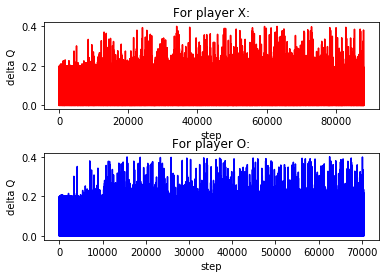

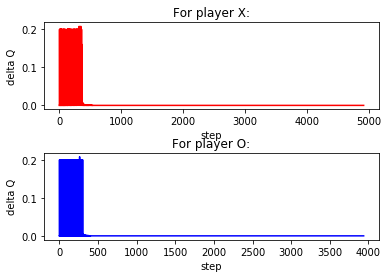

In [11]:
game = TicTacToe(SARSA, SARSA, 0.2)
game.train(20000, epsilon=0.2, with_epsilon=1, counter=100, graph=True)
game = TicTacToe(SARSA, SARSA, 0.2)
res = game.train(1000, epsilon=0, with_epsilon=1, counter=100, graph=True)

Легко заметить, что это является плохим критерием сходимости: из-за наличия положительного $\varepsilon$ у нас происходят постоянные колебания: если агент в текущем состоянии решил вдруг выбрать не заведомо хорошее действия, ведущее его к победе, а действие, приводящее к проигрышу на следующем ходу, понятно, что это может серьёзно отразиться на ценности состояний, которые ведут в текущее.

При $\varepsilon = 0$ алгоритмы ведут себя жадно и по-минимуму исследуют состояния, в результате они сходятся, даже не достигнув оптимума, что легко можно проверить при запуске пары игр против них

Тем не менее, при $\varepsilon > 0 \;\;  \Delta Q(s, a)$ не сходится, а при $\varepsilon = 0$ — сходится. Отсюда можно сделать вывод, что данный метод оценки скорости сходимости неактуален

### 2. Сходимость к $P_{draw} = 1$
В качестве альтернативной метрики предложим количество итераций алгоритма, после которых крестики и нолики начнут всегда играть вничью. В рамках обучения в целом мы предполагаем, что игра с самим собой улучшет способности алгоритма, и в результате алгоритм играет вничью, так как как крестики, так и нолики научились не проигрывать

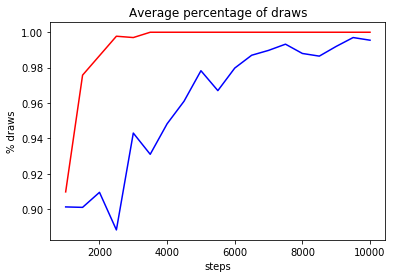

In [12]:
steps_nums = list(range(1000, 10001, 500))
iterations = 20
draws = [[], []]
for steps_num in log_progress(steps_nums, every=1):
    val = 0
    for i in range(iterations):
        game = TicTacToe(SARSA, SARSA, 0.2)
        game.train(steps_num, epsilon=0.2, with_epsilon=0.9)
        res = game.train(200, epsilon=0)
        val += res[2]/res[3]
    draws[0].append(val/iterations)
    val = 0
    for i in range(iterations):
        game = TicTacToe(QLearning, QLearning, 0.2)
        game.train(steps_num, epsilon=0.2, with_epsilon=0.9)
        res = game.train(200, epsilon=0)
        val += res[2]/res[3]
    draws[1].append(val/iterations)
plt.title('Average percentage of draws')
plt.xlabel('steps')
plt.ylabel('% draws')
plt.plot(steps_nums, draws[0], 'r', steps_nums, draws[1], 'b')
plt.show()

По графику можно заметить, что в данных терминах сходимости **Q-learning** всё-таки сходится подольше